In [1]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm import tqdm # progress bar
import math
import sys

In [2]:
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [3]:
# defining the files directory and testing directory
files_dir = './__train'
test_dir = './trying'

class MalariaImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.png']
        
        
        # classes: 0 index is reserved for background
        self.classes = ['background', 'Esch','LT','LR-ET', 'Lsch', 'R', 'Seg', 'MT', 'DEBRIS', 'WBC']
        self.hiclasses = ['background','Ring','Trophozoite','Schizont','DEBRIS','WBC']

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            l = self.classes.index(member.find('name').text)
            labels.append(l)
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            if ymin >= ymax:
                print(annot_file_path)
                print(ymin,ymax)
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        

        # convert boxes into a torch.Tensor
        if len(boxes) == 0:
            boxes.append([0,0,self.width,self.height])
            labels.append(0)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)

In [4]:
# check dataset
dataset = MalariaImagesDataset(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')
dl = len(dataset)
# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[2]
print(img.shape, '\n',target)

length of dataset =  413 

(224, 224, 3) 
 {'boxes': tensor([[125.1288, 201.3825, 148.3068, 223.7825],
        [210.0608,  31.0990, 223.3517,  48.0621],
        [ 91.5774, 112.8699, 102.9233, 127.2233],
        [154.6281,  71.5495, 167.5948,  88.5126],
        [ 50.4081, 126.3534,  63.8611, 140.0544]]), 'labels': tensor([1, 6, 7, 8, 8]), 'area': tensor([519.1876, 225.4549, 162.8519, 219.9556, 184.3187]), 'iscrowd': tensor([0, 0, 0, 0, 0]), 'image_id': tensor([2])}


## Visualization

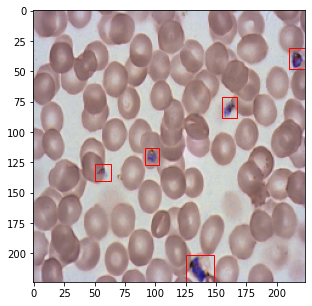

In [5]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 1,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[2]
plot_img_bbox(img, target)

## Model

In [6]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    # model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes = num_classes)
    # model = torchvision.models.vgg16(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

## Augmentations

In [7]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    if train:
        return A.Compose([
                            A.HorizontalFlip(p=0.3),
                            A.VerticalFlip(p=0.3),
                            A.RandomBrightnessContrast(p=0.1),
                            A.ColorJitter(p=0.1),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2() 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2()
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## Preparing dataset

In [8]:
# use our dataset and defined transformations
dataset = MalariaImagesDataset(files_dir, 224, 224, transforms= get_transform(train=True))
dataset_test = MalariaImagesDataset(test_dir, 224, 224, transforms= get_transform(train=False))

# 590
# split the dataset in train and test set
#torch.manual_seed(1)
#indices = torch.randperm(len(dataset)).tolist()
# # train test split
#test_split = 0.3
#tsize = int(len(dataset)*test_split)
#dataset_train = torch.utils.data.Subset(dataset, indices[:-tsize])
#dataset_test = torch.utils.data.Subset(dataset, np.arange(dl)[-tsize:])

print(len(dataset))
#print(len(dataset_train))
print(len(dataset_test))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)



413
177


## Training

In [9]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(torch.cuda.is_available())
num_classes = 10

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=40,
                                               gamma=0.1)

True


In [10]:
# training 
num_epochs = 50

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/207]  eta: 0:21:12  lr: 0.000058  loss: 2.9687 (2.9687)  loss_classifier: 2.2644 (2.2644)  loss_box_reg: 0.0046 (0.0046)  loss_objectness: 0.6921 (0.6921)  loss_rpn_box_reg: 0.0075 (0.0075)  time: 6.1465  data: 0.1047  max mem: 1619
Epoch: [0]  [ 10/207]  eta: 0:03:47  lr: 0.000543  loss: 2.9669 (2.9269)  loss_classifier: 2.1605 (2.0479)  loss_box_reg: 0.0201 (0.0226)  loss_objectness: 0.6889 (0.6891)  loss_rpn_box_reg: 0.0494 (0.1673)  time: 1.1533  data: 0.0960  max mem: 1881
Epoch: [0]  [ 20/207]  eta: 0:02:54  lr: 0.001028  loss: 1.9107 (2.1504)  loss_classifier: 1.2175 (1.3278)  loss_box_reg: 0.0201 (0.0275)  loss_objectness: 0.6830 (0.6459)  loss_rpn_box_reg: 0.0494 (0.1492)  time: 0.6727  data: 0.0953  max mem: 1881
Epoch: [0]  [ 30/207]  eta: 0:02:29  lr: 0.001513  loss: 0.8635 (1.7220)  loss_classifier: 0.2874 (0.9803)  loss_box_reg: 0.0154 (0.0285)  loss_objectness: 0.4810 (0.5727)  loss_rpn_box_reg: 0.0576 (0.1406)  time: 0.6719  data: 0.0930  max mem: 1882


Epoch: [1]  [ 50/207]  eta: 0:01:41  lr: 0.010000  loss: 0.5840 (0.5993)  loss_classifier: 0.2307 (0.2426)  loss_box_reg: 0.2116 (0.2246)  loss_objectness: 0.0256 (0.0491)  loss_rpn_box_reg: 0.0310 (0.0829)  time: 0.6493  data: 0.0797  max mem: 1882
Epoch: [1]  [ 60/207]  eta: 0:01:35  lr: 0.010000  loss: 0.6460 (0.6665)  loss_classifier: 0.2537 (0.2613)  loss_box_reg: 0.2116 (0.2406)  loss_objectness: 0.0378 (0.0690)  loss_rpn_box_reg: 0.0371 (0.0957)  time: 0.6517  data: 0.0811  max mem: 1882
Epoch: [1]  [ 70/207]  eta: 0:01:28  lr: 0.010000  loss: 0.6068 (0.6575)  loss_classifier: 0.2590 (0.2606)  loss_box_reg: 0.2301 (0.2363)  loss_objectness: 0.0624 (0.0683)  loss_rpn_box_reg: 0.0371 (0.0922)  time: 0.6521  data: 0.0818  max mem: 1882
Epoch: [1]  [ 80/207]  eta: 0:01:22  lr: 0.010000  loss: 0.6068 (0.6716)  loss_classifier: 0.2554 (0.2665)  loss_box_reg: 0.2301 (0.2409)  loss_objectness: 0.0495 (0.0700)  loss_rpn_box_reg: 0.0558 (0.0941)  time: 0.6506  data: 0.0792  max mem: 1882


Epoch: [2]  [100/207]  eta: 0:01:09  lr: 0.010000  loss: 0.5945 (0.6713)  loss_classifier: 0.2543 (0.2962)  loss_box_reg: 0.2073 (0.2510)  loss_objectness: 0.0297 (0.0519)  loss_rpn_box_reg: 0.0253 (0.0722)  time: 0.6525  data: 0.0810  max mem: 1882
Epoch: [2]  [110/207]  eta: 0:01:03  lr: 0.010000  loss: 0.5173 (0.6579)  loss_classifier: 0.2361 (0.2905)  loss_box_reg: 0.1922 (0.2459)  loss_objectness: 0.0280 (0.0502)  loss_rpn_box_reg: 0.0253 (0.0713)  time: 0.6528  data: 0.0802  max mem: 1882
Epoch: [2]  [120/207]  eta: 0:00:56  lr: 0.010000  loss: 0.4143 (0.6308)  loss_classifier: 0.1795 (0.2792)  loss_box_reg: 0.1375 (0.2348)  loss_objectness: 0.0218 (0.0477)  loss_rpn_box_reg: 0.0210 (0.0691)  time: 0.6531  data: 0.0798  max mem: 1882
Epoch: [2]  [130/207]  eta: 0:00:50  lr: 0.010000  loss: 0.3466 (0.6181)  loss_classifier: 0.1603 (0.2739)  loss_box_reg: 0.1138 (0.2304)  loss_objectness: 0.0196 (0.0467)  loss_rpn_box_reg: 0.0190 (0.0671)  time: 0.6526  data: 0.0801  max mem: 1882


Epoch: [3]  [150/207]  eta: 0:00:38  lr: 0.010000  loss: 0.5348 (0.5634)  loss_classifier: 0.2314 (0.2557)  loss_box_reg: 0.1886 (0.2163)  loss_objectness: 0.0215 (0.0348)  loss_rpn_box_reg: 0.0370 (0.0566)  time: 0.6655  data: 0.0886  max mem: 1882
Epoch: [3]  [160/207]  eta: 0:00:31  lr: 0.010000  loss: 0.5348 (0.5601)  loss_classifier: 0.2326 (0.2535)  loss_box_reg: 0.1938 (0.2154)  loss_objectness: 0.0187 (0.0342)  loss_rpn_box_reg: 0.0209 (0.0570)  time: 0.6637  data: 0.0868  max mem: 1882
Epoch: [3]  [170/207]  eta: 0:00:24  lr: 0.010000  loss: 0.4965 (0.5592)  loss_classifier: 0.2653 (0.2553)  loss_box_reg: 0.1954 (0.2156)  loss_objectness: 0.0192 (0.0334)  loss_rpn_box_reg: 0.0231 (0.0548)  time: 0.6676  data: 0.0904  max mem: 1882
Epoch: [3]  [180/207]  eta: 0:00:18  lr: 0.010000  loss: 0.5936 (0.5633)  loss_classifier: 0.3067 (0.2597)  loss_box_reg: 0.2304 (0.2176)  loss_objectness: 0.0162 (0.0327)  loss_rpn_box_reg: 0.0160 (0.0533)  time: 0.6758  data: 0.0958  max mem: 1882


Epoch: [4]  [200/207]  eta: 0:00:04  lr: 0.010000  loss: 0.4418 (0.5324)  loss_classifier: 0.2198 (0.2489)  loss_box_reg: 0.1882 (0.2081)  loss_objectness: 0.0276 (0.0274)  loss_rpn_box_reg: 0.0229 (0.0481)  time: 0.6585  data: 0.0808  max mem: 1882
Epoch: [4]  [206/207]  eta: 0:00:00  lr: 0.010000  loss: 0.4977 (0.5335)  loss_classifier: 0.2256 (0.2500)  loss_box_reg: 0.1818 (0.2077)  loss_objectness: 0.0375 (0.0282)  loss_rpn_box_reg: 0.0229 (0.0476)  time: 0.6418  data: 0.0784  max mem: 1882
Epoch: [4] Total time: 0:02:15 (0.6569 s / it)
creating index...
index created!
Test:  [ 0/89]  eta: 0:00:58  model_time: 0.5696 (0.5696)  evaluator_time: 0.0045 (0.0045)  time: 0.6537  data: 0.0787  max mem: 1882
Test:  [88/89]  eta: 0:00:00  model_time: 0.2657 (0.2663)  evaluator_time: 0.0039 (0.0048)  time: 0.3403  data: 0.0754  max mem: 1882
Test: Total time: 0:00:31 (0.3486 s / it)
Averaged stats: model_time: 0.2657 (0.2663)  evaluator_time: 0.0039 (0.0048)
Accumulating evaluation results..

Epoch: [6]  [  0/207]  eta: 0:02:17  lr: 0.010000  loss: 0.5075 (0.5075)  loss_classifier: 0.1603 (0.1603)  loss_box_reg: 0.1532 (0.1532)  loss_objectness: 0.0274 (0.0274)  loss_rpn_box_reg: 0.1666 (0.1666)  time: 0.6639  data: 0.0855  max mem: 1882
Epoch: [6]  [ 10/207]  eta: 0:02:09  lr: 0.010000  loss: 0.4318 (0.5530)  loss_classifier: 0.2165 (0.2050)  loss_box_reg: 0.1627 (0.1849)  loss_objectness: 0.0146 (0.0624)  loss_rpn_box_reg: 0.0335 (0.1007)  time: 0.6564  data: 0.0802  max mem: 1882
Epoch: [6]  [ 20/207]  eta: 0:02:02  lr: 0.010000  loss: 0.4318 (0.5182)  loss_classifier: 0.2486 (0.2202)  loss_box_reg: 0.1757 (0.1893)  loss_objectness: 0.0165 (0.0437)  loss_rpn_box_reg: 0.0173 (0.0651)  time: 0.6539  data: 0.0807  max mem: 1882
Epoch: [6]  [ 30/207]  eta: 0:01:56  lr: 0.010000  loss: 0.4500 (0.5205)  loss_classifier: 0.2492 (0.2291)  loss_box_reg: 0.1990 (0.1990)  loss_objectness: 0.0173 (0.0353)  loss_rpn_box_reg: 0.0291 (0.0571)  time: 0.6551  data: 0.0825  max mem: 1882


Epoch: [7]  [ 50/207]  eta: 0:01:43  lr: 0.010000  loss: 0.5063 (0.5347)  loss_classifier: 0.2524 (0.2735)  loss_box_reg: 0.1932 (0.2110)  loss_objectness: 0.0160 (0.0169)  loss_rpn_box_reg: 0.0129 (0.0334)  time: 0.6562  data: 0.0796  max mem: 1882
Epoch: [7]  [ 60/207]  eta: 0:01:36  lr: 0.010000  loss: 0.4465 (0.5191)  loss_classifier: 0.2168 (0.2645)  loss_box_reg: 0.1824 (0.2057)  loss_objectness: 0.0116 (0.0163)  loss_rpn_box_reg: 0.0129 (0.0326)  time: 0.6562  data: 0.0788  max mem: 1882
Epoch: [7]  [ 70/207]  eta: 0:01:29  lr: 0.010000  loss: 0.4487 (0.5331)  loss_classifier: 0.2185 (0.2610)  loss_box_reg: 0.1824 (0.2057)  loss_objectness: 0.0143 (0.0247)  loss_rpn_box_reg: 0.0246 (0.0417)  time: 0.6568  data: 0.0783  max mem: 1882
Epoch: [7]  [ 80/207]  eta: 0:01:23  lr: 0.010000  loss: 0.4774 (0.5158)  loss_classifier: 0.1944 (0.2494)  loss_box_reg: 0.1776 (0.2004)  loss_objectness: 0.0226 (0.0260)  loss_rpn_box_reg: 0.0185 (0.0401)  time: 0.6561  data: 0.0800  max mem: 1882


Epoch: [8]  [100/207]  eta: 0:01:10  lr: 0.010000  loss: 0.4630 (0.4939)  loss_classifier: 0.2326 (0.2399)  loss_box_reg: 0.1508 (0.1997)  loss_objectness: 0.0149 (0.0180)  loss_rpn_box_reg: 0.0172 (0.0363)  time: 0.6579  data: 0.0804  max mem: 1882
Epoch: [8]  [110/207]  eta: 0:01:03  lr: 0.010000  loss: 0.4269 (0.4942)  loss_classifier: 0.2124 (0.2406)  loss_box_reg: 0.1508 (0.2010)  loss_objectness: 0.0135 (0.0176)  loss_rpn_box_reg: 0.0168 (0.0350)  time: 0.6573  data: 0.0803  max mem: 1882
Epoch: [8]  [120/207]  eta: 0:00:57  lr: 0.010000  loss: 0.4552 (0.4942)  loss_classifier: 0.2295 (0.2417)  loss_box_reg: 0.1903 (0.2016)  loss_objectness: 0.0121 (0.0170)  loss_rpn_box_reg: 0.0165 (0.0338)  time: 0.6603  data: 0.0813  max mem: 1882
Epoch: [8]  [130/207]  eta: 0:00:50  lr: 0.010000  loss: 0.5162 (0.5020)  loss_classifier: 0.2438 (0.2463)  loss_box_reg: 0.2153 (0.2064)  loss_objectness: 0.0095 (0.0166)  loss_rpn_box_reg: 0.0131 (0.0327)  time: 0.6593  data: 0.0803  max mem: 1882


Epoch: [9]  [150/207]  eta: 0:00:37  lr: 0.010000  loss: 0.3500 (0.4893)  loss_classifier: 0.1733 (0.2425)  loss_box_reg: 0.1486 (0.1988)  loss_objectness: 0.0078 (0.0166)  loss_rpn_box_reg: 0.0140 (0.0314)  time: 0.6616  data: 0.0814  max mem: 1882
Epoch: [9]  [160/207]  eta: 0:00:30  lr: 0.010000  loss: 0.5109 (0.5025)  loss_classifier: 0.2587 (0.2459)  loss_box_reg: 0.2044 (0.2042)  loss_objectness: 0.0087 (0.0183)  loss_rpn_box_reg: 0.0201 (0.0342)  time: 0.6615  data: 0.0802  max mem: 1882
Epoch: [9]  [170/207]  eta: 0:00:24  lr: 0.010000  loss: 0.5667 (0.5028)  loss_classifier: 0.2600 (0.2464)  loss_box_reg: 0.2414 (0.2045)  loss_objectness: 0.0105 (0.0178)  loss_rpn_box_reg: 0.0207 (0.0341)  time: 0.6596  data: 0.0808  max mem: 1882
Epoch: [9]  [180/207]  eta: 0:00:17  lr: 0.010000  loss: 0.4055 (0.4984)  loss_classifier: 0.1919 (0.2443)  loss_box_reg: 0.1807 (0.2032)  loss_objectness: 0.0105 (0.0174)  loss_rpn_box_reg: 0.0146 (0.0336)  time: 0.6617  data: 0.0794  max mem: 1882


Epoch: [10]  [200/207]  eta: 0:00:04  lr: 0.010000  loss: 0.4057 (0.4747)  loss_classifier: 0.2082 (0.2261)  loss_box_reg: 0.1731 (0.1948)  loss_objectness: 0.0146 (0.0207)  loss_rpn_box_reg: 0.0128 (0.0331)  time: 0.6566  data: 0.0808  max mem: 1882
Epoch: [10]  [206/207]  eta: 0:00:00  lr: 0.010000  loss: 0.3804 (0.4702)  loss_classifier: 0.1833 (0.2235)  loss_box_reg: 0.1574 (0.1932)  loss_objectness: 0.0112 (0.0204)  loss_rpn_box_reg: 0.0128 (0.0331)  time: 0.6414  data: 0.0779  max mem: 1882
Epoch: [10] Total time: 0:02:15 (0.6556 s / it)
creating index...
index created!
Test:  [ 0/89]  eta: 0:00:37  model_time: 0.3343 (0.3343)  evaluator_time: 0.0039 (0.0039)  time: 0.4189  data: 0.0777  max mem: 1882
Test:  [88/89]  eta: 0:00:00  model_time: 0.2650 (0.2636)  evaluator_time: 0.0039 (0.0047)  time: 0.3386  data: 0.0754  max mem: 1882
Test: Total time: 0:00:30 (0.3451 s / it)
Averaged stats: model_time: 0.2650 (0.2636)  evaluator_time: 0.0039 (0.0047)
Accumulating evaluation result

Epoch: [12]  [  0/207]  eta: 0:02:17  lr: 0.010000  loss: 0.4985 (0.4985)  loss_classifier: 0.2243 (0.2243)  loss_box_reg: 0.2448 (0.2448)  loss_objectness: 0.0112 (0.0112)  loss_rpn_box_reg: 0.0183 (0.0183)  time: 0.6662  data: 0.0918  max mem: 1882
Epoch: [12]  [ 10/207]  eta: 0:02:09  lr: 0.010000  loss: 0.3379 (0.3503)  loss_classifier: 0.1840 (0.1702)  loss_box_reg: 0.1429 (0.1543)  loss_objectness: 0.0067 (0.0080)  loss_rpn_box_reg: 0.0121 (0.0179)  time: 0.6576  data: 0.0810  max mem: 1882
Epoch: [12]  [ 20/207]  eta: 0:02:02  lr: 0.010000  loss: 0.3664 (0.3891)  loss_classifier: 0.1809 (0.1928)  loss_box_reg: 0.1520 (0.1719)  loss_objectness: 0.0076 (0.0090)  loss_rpn_box_reg: 0.0101 (0.0153)  time: 0.6559  data: 0.0802  max mem: 1882
Epoch: [12]  [ 30/207]  eta: 0:01:56  lr: 0.010000  loss: 0.3839 (0.3992)  loss_classifier: 0.1809 (0.1928)  loss_box_reg: 0.1710 (0.1729)  loss_objectness: 0.0093 (0.0122)  loss_rpn_box_reg: 0.0134 (0.0213)  time: 0.6554  data: 0.0801  max mem: 1

Epoch: [13]  [ 50/207]  eta: 0:01:43  lr: 0.010000  loss: 0.3500 (0.4111)  loss_classifier: 0.1807 (0.2007)  loss_box_reg: 0.1421 (0.1661)  loss_objectness: 0.0127 (0.0167)  loss_rpn_box_reg: 0.0215 (0.0276)  time: 0.6595  data: 0.0828  max mem: 1882
Epoch: [13]  [ 60/207]  eta: 0:01:36  lr: 0.010000  loss: 0.3848 (0.4235)  loss_classifier: 0.1979 (0.2004)  loss_box_reg: 0.1445 (0.1687)  loss_objectness: 0.0144 (0.0177)  loss_rpn_box_reg: 0.0193 (0.0366)  time: 0.6546  data: 0.0807  max mem: 1882
Epoch: [13]  [ 70/207]  eta: 0:01:30  lr: 0.010000  loss: 0.5143 (0.4413)  loss_classifier: 0.2247 (0.2101)  loss_box_reg: 0.1929 (0.1767)  loss_objectness: 0.0191 (0.0175)  loss_rpn_box_reg: 0.0154 (0.0371)  time: 0.6537  data: 0.0793  max mem: 1882
Epoch: [13]  [ 80/207]  eta: 0:01:23  lr: 0.010000  loss: 0.4418 (0.4352)  loss_classifier: 0.2229 (0.2070)  loss_box_reg: 0.1734 (0.1754)  loss_objectness: 0.0127 (0.0173)  loss_rpn_box_reg: 0.0195 (0.0356)  time: 0.6540  data: 0.0786  max mem: 1

Epoch: [14]  [100/207]  eta: 0:01:10  lr: 0.010000  loss: 0.5232 (0.4551)  loss_classifier: 0.2344 (0.2245)  loss_box_reg: 0.1966 (0.1929)  loss_objectness: 0.0086 (0.0116)  loss_rpn_box_reg: 0.0136 (0.0261)  time: 0.6557  data: 0.0791  max mem: 1882
Epoch: [14]  [110/207]  eta: 0:01:03  lr: 0.010000  loss: 0.4401 (0.4590)  loss_classifier: 0.1904 (0.2276)  loss_box_reg: 0.1966 (0.1945)  loss_objectness: 0.0065 (0.0112)  loss_rpn_box_reg: 0.0136 (0.0257)  time: 0.6550  data: 0.0799  max mem: 1882
Epoch: [14]  [120/207]  eta: 0:00:57  lr: 0.010000  loss: 0.4546 (0.4608)  loss_classifier: 0.1640 (0.2251)  loss_box_reg: 0.1995 (0.1932)  loss_objectness: 0.0085 (0.0132)  loss_rpn_box_reg: 0.0143 (0.0293)  time: 0.6552  data: 0.0802  max mem: 1882
Epoch: [14]  [130/207]  eta: 0:00:50  lr: 0.010000  loss: 0.4141 (0.4564)  loss_classifier: 0.1738 (0.2225)  loss_box_reg: 0.1757 (0.1916)  loss_objectness: 0.0099 (0.0133)  loss_rpn_box_reg: 0.0170 (0.0290)  time: 0.6571  data: 0.0809  max mem: 1

Epoch: [15]  [150/207]  eta: 0:00:37  lr: 0.010000  loss: 0.5088 (0.4290)  loss_classifier: 0.2202 (0.2095)  loss_box_reg: 0.2201 (0.1813)  loss_objectness: 0.0046 (0.0105)  loss_rpn_box_reg: 0.0118 (0.0277)  time: 0.6572  data: 0.0797  max mem: 1882
Epoch: [15]  [160/207]  eta: 0:00:30  lr: 0.010000  loss: 0.4314 (0.4276)  loss_classifier: 0.2152 (0.2093)  loss_box_reg: 0.1982 (0.1809)  loss_objectness: 0.0081 (0.0103)  loss_rpn_box_reg: 0.0119 (0.0271)  time: 0.6577  data: 0.0786  max mem: 1882
Epoch: [15]  [170/207]  eta: 0:00:24  lr: 0.010000  loss: 0.3830 (0.4280)  loss_classifier: 0.1740 (0.2090)  loss_box_reg: 0.1694 (0.1818)  loss_objectness: 0.0056 (0.0102)  loss_rpn_box_reg: 0.0190 (0.0270)  time: 0.6608  data: 0.0796  max mem: 1882
Epoch: [15]  [180/207]  eta: 0:00:17  lr: 0.010000  loss: 0.3546 (0.4335)  loss_classifier: 0.1716 (0.2080)  loss_box_reg: 0.1595 (0.1826)  loss_objectness: 0.0097 (0.0137)  loss_rpn_box_reg: 0.0281 (0.0293)  time: 0.6594  data: 0.0799  max mem: 1

Epoch: [16]  [200/207]  eta: 0:00:04  lr: 0.010000  loss: 0.2919 (0.4164)  loss_classifier: 0.1630 (0.1996)  loss_box_reg: 0.1265 (0.1754)  loss_objectness: 0.0117 (0.0128)  loss_rpn_box_reg: 0.0141 (0.0286)  time: 0.6567  data: 0.0810  max mem: 1882
Epoch: [16]  [206/207]  eta: 0:00:00  lr: 0.010000  loss: 0.3081 (0.4152)  loss_classifier: 0.1284 (0.1980)  loss_box_reg: 0.1288 (0.1745)  loss_objectness: 0.0114 (0.0136)  loss_rpn_box_reg: 0.0303 (0.0291)  time: 0.6407  data: 0.0790  max mem: 1882
Epoch: [16] Total time: 0:02:15 (0.6568 s / it)
creating index...
index created!
Test:  [ 0/89]  eta: 0:00:52  model_time: 0.5005 (0.5005)  evaluator_time: 0.0029 (0.0029)  time: 0.5855  data: 0.0791  max mem: 1882
Test:  [88/89]  eta: 0:00:00  model_time: 0.2625 (0.2658)  evaluator_time: 0.0029 (0.0041)  time: 0.3371  data: 0.0748  max mem: 1882
Test: Total time: 0:00:30 (0.3475 s / it)
Averaged stats: model_time: 0.2625 (0.2658)  evaluator_time: 0.0029 (0.0041)
Accumulating evaluation result

Epoch: [18]  [  0/207]  eta: 0:02:16  lr: 0.010000  loss: 0.6539 (0.6539)  loss_classifier: 0.2730 (0.2730)  loss_box_reg: 0.1788 (0.1788)  loss_objectness: 0.0884 (0.0884)  loss_rpn_box_reg: 0.1137 (0.1137)  time: 0.6581  data: 0.0821  max mem: 1882
Epoch: [18]  [ 10/207]  eta: 0:02:08  lr: 0.010000  loss: 0.3880 (0.4370)  loss_classifier: 0.1739 (0.1843)  loss_box_reg: 0.1382 (0.1436)  loss_objectness: 0.0163 (0.0238)  loss_rpn_box_reg: 0.0365 (0.0854)  time: 0.6512  data: 0.0805  max mem: 1882
Epoch: [18]  [ 20/207]  eta: 0:02:02  lr: 0.010000  loss: 0.3300 (0.3969)  loss_classifier: 0.1703 (0.1738)  loss_box_reg: 0.1369 (0.1463)  loss_objectness: 0.0135 (0.0193)  loss_rpn_box_reg: 0.0195 (0.0575)  time: 0.6540  data: 0.0812  max mem: 1882
Epoch: [18]  [ 30/207]  eta: 0:01:55  lr: 0.010000  loss: 0.3258 (0.3895)  loss_classifier: 0.1435 (0.1760)  loss_box_reg: 0.1602 (0.1526)  loss_objectness: 0.0091 (0.0169)  loss_rpn_box_reg: 0.0152 (0.0440)  time: 0.6562  data: 0.0820  max mem: 1

Epoch: [19]  [ 50/207]  eta: 0:01:43  lr: 0.010000  loss: 0.3676 (0.3821)  loss_classifier: 0.1416 (0.1750)  loss_box_reg: 0.1691 (0.1706)  loss_objectness: 0.0076 (0.0103)  loss_rpn_box_reg: 0.0162 (0.0261)  time: 0.6603  data: 0.0812  max mem: 1882
Epoch: [19]  [ 60/207]  eta: 0:01:37  lr: 0.010000  loss: 0.3869 (0.4016)  loss_classifier: 0.1822 (0.1879)  loss_box_reg: 0.1722 (0.1773)  loss_objectness: 0.0098 (0.0110)  loss_rpn_box_reg: 0.0176 (0.0254)  time: 0.6594  data: 0.0812  max mem: 1882
Epoch: [19]  [ 70/207]  eta: 0:01:30  lr: 0.010000  loss: 0.3505 (0.3946)  loss_classifier: 0.1712 (0.1876)  loss_box_reg: 0.1358 (0.1724)  loss_objectness: 0.0095 (0.0109)  loss_rpn_box_reg: 0.0075 (0.0238)  time: 0.6583  data: 0.0800  max mem: 1882
Epoch: [19]  [ 80/207]  eta: 0:01:23  lr: 0.010000  loss: 0.4071 (0.4110)  loss_classifier: 0.2178 (0.1944)  loss_box_reg: 0.1692 (0.1773)  loss_objectness: 0.0084 (0.0127)  loss_rpn_box_reg: 0.0062 (0.0266)  time: 0.6593  data: 0.0798  max mem: 1

Epoch: [20]  [100/207]  eta: 0:01:10  lr: 0.010000  loss: 0.4051 (0.3876)  loss_classifier: 0.2071 (0.1787)  loss_box_reg: 0.1588 (0.1671)  loss_objectness: 0.0080 (0.0104)  loss_rpn_box_reg: 0.0108 (0.0314)  time: 0.6587  data: 0.0816  max mem: 1882
Epoch: [20]  [110/207]  eta: 0:01:03  lr: 0.010000  loss: 0.3669 (0.3856)  loss_classifier: 0.1598 (0.1748)  loss_box_reg: 0.1572 (0.1643)  loss_objectness: 0.0084 (0.0109)  loss_rpn_box_reg: 0.0162 (0.0357)  time: 0.6618  data: 0.0828  max mem: 1882
Epoch: [20]  [120/207]  eta: 0:00:57  lr: 0.010000  loss: 0.3109 (0.3869)  loss_classifier: 0.1520 (0.1770)  loss_box_reg: 0.1270 (0.1655)  loss_objectness: 0.0079 (0.0105)  loss_rpn_box_reg: 0.0133 (0.0339)  time: 0.6634  data: 0.0811  max mem: 1882
Epoch: [20]  [130/207]  eta: 0:00:50  lr: 0.010000  loss: 0.4562 (0.3904)  loss_classifier: 0.2256 (0.1808)  loss_box_reg: 0.1948 (0.1670)  loss_objectness: 0.0063 (0.0102)  loss_rpn_box_reg: 0.0085 (0.0323)  time: 0.6614  data: 0.0806  max mem: 1

Epoch: [21]  [150/207]  eta: 0:00:37  lr: 0.010000  loss: 0.3485 (0.3847)  loss_classifier: 0.1529 (0.1810)  loss_box_reg: 0.1398 (0.1623)  loss_objectness: 0.0057 (0.0114)  loss_rpn_box_reg: 0.0058 (0.0301)  time: 0.6562  data: 0.0778  max mem: 1882
Epoch: [21]  [160/207]  eta: 0:00:30  lr: 0.010000  loss: 0.3014 (0.3859)  loss_classifier: 0.1529 (0.1805)  loss_box_reg: 0.1336 (0.1640)  loss_objectness: 0.0104 (0.0115)  loss_rpn_box_reg: 0.0138 (0.0298)  time: 0.6544  data: 0.0787  max mem: 1882
Epoch: [21]  [170/207]  eta: 0:00:24  lr: 0.010000  loss: 0.3711 (0.3835)  loss_classifier: 0.1707 (0.1796)  loss_box_reg: 0.1408 (0.1629)  loss_objectness: 0.0095 (0.0114)  loss_rpn_box_reg: 0.0146 (0.0296)  time: 0.6538  data: 0.0804  max mem: 1882
Epoch: [21]  [180/207]  eta: 0:00:17  lr: 0.010000  loss: 0.3152 (0.3789)  loss_classifier: 0.1478 (0.1776)  loss_box_reg: 0.1321 (0.1614)  loss_objectness: 0.0089 (0.0114)  loss_rpn_box_reg: 0.0106 (0.0285)  time: 0.6556  data: 0.0799  max mem: 1

Epoch: [22]  [200/207]  eta: 0:00:04  lr: 0.010000  loss: 0.3581 (0.3738)  loss_classifier: 0.1635 (0.1682)  loss_box_reg: 0.1497 (0.1583)  loss_objectness: 0.0092 (0.0191)  loss_rpn_box_reg: 0.0132 (0.0283)  time: 0.6564  data: 0.0821  max mem: 1882
Epoch: [22]  [206/207]  eta: 0:00:00  lr: 0.010000  loss: 0.3513 (0.3729)  loss_classifier: 0.1787 (0.1684)  loss_box_reg: 0.1415 (0.1579)  loss_objectness: 0.0067 (0.0187)  loss_rpn_box_reg: 0.0100 (0.0279)  time: 0.6421  data: 0.0799  max mem: 1882
Epoch: [22] Total time: 0:02:15 (0.6556 s / it)
creating index...
index created!
Test:  [ 0/89]  eta: 0:00:47  model_time: 0.4530 (0.4530)  evaluator_time: 0.0049 (0.0049)  time: 0.5370  data: 0.0772  max mem: 1882
Test:  [88/89]  eta: 0:00:00  model_time: 0.2668 (0.2678)  evaluator_time: 0.0049 (0.0044)  time: 0.3493  data: 0.0776  max mem: 1882
Test: Total time: 0:00:31 (0.3502 s / it)
Averaged stats: model_time: 0.2668 (0.2678)  evaluator_time: 0.0049 (0.0044)
Accumulating evaluation result

Epoch: [24]  [  0/207]  eta: 0:02:15  lr: 0.010000  loss: 0.5415 (0.5415)  loss_classifier: 0.2773 (0.2773)  loss_box_reg: 0.2344 (0.2344)  loss_objectness: 0.0225 (0.0225)  loss_rpn_box_reg: 0.0072 (0.0072)  time: 0.6553  data: 0.0870  max mem: 1882
Epoch: [24]  [ 10/207]  eta: 0:02:08  lr: 0.010000  loss: 0.3252 (0.3368)  loss_classifier: 0.1460 (0.1586)  loss_box_reg: 0.1363 (0.1476)  loss_objectness: 0.0171 (0.0145)  loss_rpn_box_reg: 0.0106 (0.0161)  time: 0.6508  data: 0.0828  max mem: 1882
Epoch: [24]  [ 20/207]  eta: 0:02:01  lr: 0.010000  loss: 0.3134 (0.3277)  loss_classifier: 0.1383 (0.1484)  loss_box_reg: 0.1368 (0.1509)  loss_objectness: 0.0089 (0.0120)  loss_rpn_box_reg: 0.0102 (0.0163)  time: 0.6482  data: 0.0822  max mem: 1882
Epoch: [24]  [ 30/207]  eta: 0:01:55  lr: 0.010000  loss: 0.3322 (0.3645)  loss_classifier: 0.1494 (0.1553)  loss_box_reg: 0.1521 (0.1458)  loss_objectness: 0.0106 (0.0225)  loss_rpn_box_reg: 0.0102 (0.0410)  time: 0.6492  data: 0.0838  max mem: 1

Epoch: [25]  [ 50/207]  eta: 0:01:43  lr: 0.010000  loss: 0.2872 (0.3384)  loss_classifier: 0.1307 (0.1483)  loss_box_reg: 0.1283 (0.1508)  loss_objectness: 0.0053 (0.0106)  loss_rpn_box_reg: 0.0056 (0.0287)  time: 0.6653  data: 0.0881  max mem: 1882
Epoch: [25]  [ 60/207]  eta: 0:01:36  lr: 0.010000  loss: 0.3598 (0.3443)  loss_classifier: 0.1402 (0.1524)  loss_box_reg: 0.1576 (0.1530)  loss_objectness: 0.0051 (0.0103)  loss_rpn_box_reg: 0.0124 (0.0287)  time: 0.6582  data: 0.0865  max mem: 1882
Epoch: [25]  [ 70/207]  eta: 0:01:30  lr: 0.010000  loss: 0.3548 (0.3441)  loss_classifier: 0.1677 (0.1550)  loss_box_reg: 0.1452 (0.1526)  loss_objectness: 0.0072 (0.0099)  loss_rpn_box_reg: 0.0143 (0.0266)  time: 0.6556  data: 0.0853  max mem: 1882
Epoch: [25]  [ 80/207]  eta: 0:01:23  lr: 0.010000  loss: 0.3433 (0.3444)  loss_classifier: 0.1664 (0.1555)  loss_box_reg: 0.1452 (0.1524)  loss_objectness: 0.0060 (0.0099)  loss_rpn_box_reg: 0.0129 (0.0265)  time: 0.6708  data: 0.0871  max mem: 1

Epoch: [26]  [100/207]  eta: 0:01:15  lr: 0.010000  loss: 0.3328 (0.3708)  loss_classifier: 0.1345 (0.1648)  loss_box_reg: 0.1572 (0.1694)  loss_objectness: 0.0088 (0.0101)  loss_rpn_box_reg: 0.0209 (0.0265)  time: 0.7159  data: 0.0957  max mem: 1882
Epoch: [26]  [110/207]  eta: 0:01:08  lr: 0.010000  loss: 0.3050 (0.3636)  loss_classifier: 0.1051 (0.1615)  loss_box_reg: 0.1339 (0.1654)  loss_objectness: 0.0047 (0.0108)  loss_rpn_box_reg: 0.0117 (0.0259)  time: 0.7209  data: 0.0930  max mem: 1882
Epoch: [26]  [120/207]  eta: 0:01:02  lr: 0.010000  loss: 0.2562 (0.3561)  loss_classifier: 0.1171 (0.1588)  loss_box_reg: 0.1052 (0.1618)  loss_objectness: 0.0048 (0.0106)  loss_rpn_box_reg: 0.0063 (0.0249)  time: 0.7437  data: 0.0967  max mem: 1882
Epoch: [26]  [130/207]  eta: 0:00:54  lr: 0.010000  loss: 0.2562 (0.3496)  loss_classifier: 0.1343 (0.1562)  loss_box_reg: 0.1082 (0.1587)  loss_objectness: 0.0109 (0.0107)  loss_rpn_box_reg: 0.0082 (0.0240)  time: 0.7351  data: 0.0977  max mem: 1

Epoch: [27]  [150/207]  eta: 0:00:40  lr: 0.010000  loss: 0.4262 (0.3389)  loss_classifier: 0.1815 (0.1542)  loss_box_reg: 0.1703 (0.1514)  loss_objectness: 0.0125 (0.0099)  loss_rpn_box_reg: 0.0186 (0.0234)  time: 0.7233  data: 0.0934  max mem: 1882
Epoch: [27]  [160/207]  eta: 0:00:33  lr: 0.010000  loss: 0.4137 (0.3406)  loss_classifier: 0.1839 (0.1534)  loss_box_reg: 0.1703 (0.1535)  loss_objectness: 0.0128 (0.0100)  loss_rpn_box_reg: 0.0186 (0.0237)  time: 0.7149  data: 0.0950  max mem: 1882
Epoch: [27]  [170/207]  eta: 0:00:26  lr: 0.010000  loss: 0.4067 (0.3482)  loss_classifier: 0.1625 (0.1562)  loss_box_reg: 0.1690 (0.1552)  loss_objectness: 0.0100 (0.0110)  loss_rpn_box_reg: 0.0161 (0.0258)  time: 0.6911  data: 0.0950  max mem: 1882
Epoch: [27]  [180/207]  eta: 0:00:18  lr: 0.010000  loss: 0.3670 (0.3482)  loss_classifier: 0.1647 (0.1574)  loss_box_reg: 0.1441 (0.1543)  loss_objectness: 0.0062 (0.0108)  loss_rpn_box_reg: 0.0161 (0.0257)  time: 0.6662  data: 0.0908  max mem: 1

Epoch: [28]  [200/207]  eta: 0:00:04  lr: 0.010000  loss: 0.2741 (0.3479)  loss_classifier: 0.1317 (0.1633)  loss_box_reg: 0.1300 (0.1508)  loss_objectness: 0.0043 (0.0080)  loss_rpn_box_reg: 0.0075 (0.0258)  time: 0.6714  data: 0.0848  max mem: 1882
Epoch: [28]  [206/207]  eta: 0:00:00  lr: 0.010000  loss: 0.2575 (0.3476)  loss_classifier: 0.1269 (0.1633)  loss_box_reg: 0.1147 (0.1507)  loss_objectness: 0.0043 (0.0080)  loss_rpn_box_reg: 0.0075 (0.0255)  time: 0.6569  data: 0.0819  max mem: 1882
Epoch: [28] Total time: 0:02:21 (0.6814 s / it)
creating index...
index created!
Test:  [ 0/89]  eta: 0:00:45  model_time: 0.4227 (0.4227)  evaluator_time: 0.0049 (0.0049)  time: 0.5112  data: 0.0826  max mem: 1882
Test:  [88/89]  eta: 0:00:00  model_time: 0.2580 (0.2601)  evaluator_time: 0.0039 (0.0041)  time: 0.3351  data: 0.0772  max mem: 1882
Test: Total time: 0:00:30 (0.3428 s / it)
Averaged stats: model_time: 0.2580 (0.2601)  evaluator_time: 0.0039 (0.0041)
Accumulating evaluation result

Epoch: [30]  [  0/207]  eta: 0:02:20  lr: 0.010000  loss: 0.2342 (0.2342)  loss_classifier: 0.1195 (0.1195)  loss_box_reg: 0.1017 (0.1017)  loss_objectness: 0.0100 (0.0100)  loss_rpn_box_reg: 0.0031 (0.0031)  time: 0.6789  data: 0.0954  max mem: 1882
Epoch: [30]  [ 10/207]  eta: 0:02:11  lr: 0.010000  loss: 0.2342 (0.2779)  loss_classifier: 0.1142 (0.1219)  loss_box_reg: 0.1017 (0.1345)  loss_objectness: 0.0087 (0.0092)  loss_rpn_box_reg: 0.0088 (0.0123)  time: 0.6693  data: 0.0819  max mem: 1882
Epoch: [30]  [ 20/207]  eta: 0:02:04  lr: 0.010000  loss: 0.2306 (0.2789)  loss_classifier: 0.1142 (0.1257)  loss_box_reg: 0.1004 (0.1285)  loss_objectness: 0.0075 (0.0088)  loss_rpn_box_reg: 0.0088 (0.0159)  time: 0.6679  data: 0.0809  max mem: 1882
Epoch: [30]  [ 30/207]  eta: 0:01:58  lr: 0.010000  loss: 0.2574 (0.2899)  loss_classifier: 0.1236 (0.1307)  loss_box_reg: 0.1125 (0.1354)  loss_objectness: 0.0074 (0.0089)  loss_rpn_box_reg: 0.0095 (0.0149)  time: 0.6723  data: 0.0829  max mem: 1

Epoch: [31]  [ 50/207]  eta: 0:01:46  lr: 0.010000  loss: 0.3170 (0.3556)  loss_classifier: 0.1274 (0.1559)  loss_box_reg: 0.1414 (0.1574)  loss_objectness: 0.0038 (0.0071)  loss_rpn_box_reg: 0.0122 (0.0352)  time: 0.6881  data: 0.0933  max mem: 1882
Epoch: [31]  [ 60/207]  eta: 0:01:39  lr: 0.010000  loss: 0.2374 (0.3368)  loss_classifier: 0.1085 (0.1479)  loss_box_reg: 0.1173 (0.1505)  loss_objectness: 0.0033 (0.0071)  loss_rpn_box_reg: 0.0090 (0.0313)  time: 0.6972  data: 0.0939  max mem: 1882
Epoch: [31]  [ 70/207]  eta: 0:01:32  lr: 0.010000  loss: 0.2867 (0.3365)  loss_classifier: 0.1184 (0.1476)  loss_box_reg: 0.1173 (0.1521)  loss_objectness: 0.0041 (0.0070)  loss_rpn_box_reg: 0.0089 (0.0298)  time: 0.6784  data: 0.0897  max mem: 1882
Epoch: [31]  [ 80/207]  eta: 0:01:26  lr: 0.010000  loss: 0.2902 (0.3274)  loss_classifier: 0.1191 (0.1439)  loss_box_reg: 0.1361 (0.1480)  loss_objectness: 0.0041 (0.0071)  loss_rpn_box_reg: 0.0111 (0.0283)  time: 0.6818  data: 0.0882  max mem: 1

Epoch: [32]  [100/207]  eta: 0:01:13  lr: 0.010000  loss: 0.2386 (0.2797)  loss_classifier: 0.0918 (0.1218)  loss_box_reg: 0.1191 (0.1269)  loss_objectness: 0.0046 (0.0095)  loss_rpn_box_reg: 0.0075 (0.0215)  time: 0.6920  data: 0.0940  max mem: 1882
Epoch: [32]  [110/207]  eta: 0:01:06  lr: 0.010000  loss: 0.2923 (0.2821)  loss_classifier: 0.1121 (0.1236)  loss_box_reg: 0.1318 (0.1282)  loss_objectness: 0.0033 (0.0092)  loss_rpn_box_reg: 0.0105 (0.0211)  time: 0.7025  data: 0.0948  max mem: 1882
Epoch: [32]  [120/207]  eta: 0:01:00  lr: 0.010000  loss: 0.2934 (0.2832)  loss_classifier: 0.1325 (0.1251)  loss_box_reg: 0.1391 (0.1286)  loss_objectness: 0.0033 (0.0087)  loss_rpn_box_reg: 0.0084 (0.0208)  time: 0.7219  data: 0.0986  max mem: 1882
Epoch: [32]  [130/207]  eta: 0:00:53  lr: 0.010000  loss: 0.2644 (0.2840)  loss_classifier: 0.1325 (0.1256)  loss_box_reg: 0.1293 (0.1293)  loss_objectness: 0.0041 (0.0085)  loss_rpn_box_reg: 0.0117 (0.0207)  time: 0.7031  data: 0.0965  max mem: 1

Epoch: [33]  [150/207]  eta: 0:00:38  lr: 0.010000  loss: 0.3542 (0.3028)  loss_classifier: 0.1521 (0.1307)  loss_box_reg: 0.1501 (0.1366)  loss_objectness: 0.0135 (0.0119)  loss_rpn_box_reg: 0.0156 (0.0236)  time: 0.6662  data: 0.0949  max mem: 1882
Epoch: [33]  [160/207]  eta: 0:00:31  lr: 0.010000  loss: 0.2705 (0.3019)  loss_classifier: 0.1098 (0.1310)  loss_box_reg: 0.1259 (0.1361)  loss_objectness: 0.0083 (0.0118)  loss_rpn_box_reg: 0.0097 (0.0231)  time: 0.6723  data: 0.0944  max mem: 1882
Epoch: [33]  [170/207]  eta: 0:00:25  lr: 0.010000  loss: 0.2611 (0.3029)  loss_classifier: 0.1017 (0.1310)  loss_box_reg: 0.1196 (0.1373)  loss_objectness: 0.0057 (0.0115)  loss_rpn_box_reg: 0.0180 (0.0231)  time: 0.6859  data: 0.0942  max mem: 1882
Epoch: [33]  [180/207]  eta: 0:00:18  lr: 0.010000  loss: 0.3143 (0.3062)  loss_classifier: 0.1248 (0.1331)  loss_box_reg: 0.1279 (0.1391)  loss_objectness: 0.0063 (0.0113)  loss_rpn_box_reg: 0.0161 (0.0228)  time: 0.7063  data: 0.0967  max mem: 1

Epoch: [34]  [200/207]  eta: 0:00:04  lr: 0.010000  loss: 0.3089 (0.3013)  loss_classifier: 0.1395 (0.1306)  loss_box_reg: 0.1443 (0.1397)  loss_objectness: 0.0048 (0.0084)  loss_rpn_box_reg: 0.0099 (0.0227)  time: 0.6724  data: 0.0919  max mem: 1882
Epoch: [34]  [206/207]  eta: 0:00:00  lr: 0.010000  loss: 0.2838 (0.2992)  loss_classifier: 0.1204 (0.1295)  loss_box_reg: 0.1307 (0.1391)  loss_objectness: 0.0035 (0.0082)  loss_rpn_box_reg: 0.0089 (0.0224)  time: 0.6753  data: 0.0904  max mem: 1882
Epoch: [34] Total time: 0:02:22 (0.6885 s / it)
creating index...
index created!
Test:  [ 0/89]  eta: 0:00:50  model_time: 0.4661 (0.4661)  evaluator_time: 0.0059 (0.0059)  time: 0.5645  data: 0.0915  max mem: 1882
Test:  [88/89]  eta: 0:00:00  model_time: 0.2878 (0.2964)  evaluator_time: 0.0039 (0.0047)  time: 0.3740  data: 0.0910  max mem: 1882
Test: Total time: 0:00:35 (0.3946 s / it)
Averaged stats: model_time: 0.2878 (0.2964)  evaluator_time: 0.0039 (0.0047)
Accumulating evaluation result

Epoch: [36]  [  0/207]  eta: 0:02:25  lr: 0.010000  loss: 0.2795 (0.2795)  loss_classifier: 0.1084 (0.1084)  loss_box_reg: 0.1434 (0.1434)  loss_objectness: 0.0052 (0.0052)  loss_rpn_box_reg: 0.0226 (0.0226)  time: 0.7046  data: 0.0997  max mem: 1882
Epoch: [36]  [ 10/207]  eta: 0:02:15  lr: 0.010000  loss: 0.2635 (0.3299)  loss_classifier: 0.0860 (0.1023)  loss_box_reg: 0.1424 (0.1222)  loss_objectness: 0.0047 (0.0294)  loss_rpn_box_reg: 0.0089 (0.0761)  time: 0.6886  data: 0.0906  max mem: 1882
Epoch: [36]  [ 20/207]  eta: 0:02:08  lr: 0.010000  loss: 0.2370 (0.2939)  loss_classifier: 0.0763 (0.0977)  loss_box_reg: 0.1058 (0.1268)  loss_objectness: 0.0077 (0.0196)  loss_rpn_box_reg: 0.0126 (0.0497)  time: 0.6836  data: 0.0908  max mem: 1882
Epoch: [36]  [ 30/207]  eta: 0:02:03  lr: 0.010000  loss: 0.2450 (0.2808)  loss_classifier: 0.1048 (0.1008)  loss_box_reg: 0.1035 (0.1249)  loss_objectness: 0.0091 (0.0172)  loss_rpn_box_reg: 0.0130 (0.0379)  time: 0.7020  data: 0.0941  max mem: 1

Epoch: [37]  [ 50/207]  eta: 0:01:48  lr: 0.010000  loss: 0.2498 (0.2705)  loss_classifier: 0.0936 (0.1181)  loss_box_reg: 0.1374 (0.1337)  loss_objectness: 0.0029 (0.0054)  loss_rpn_box_reg: 0.0052 (0.0133)  time: 0.6877  data: 0.0923  max mem: 1882
Epoch: [37]  [ 60/207]  eta: 0:01:41  lr: 0.010000  loss: 0.2792 (0.2710)  loss_classifier: 0.1193 (0.1171)  loss_box_reg: 0.1374 (0.1347)  loss_objectness: 0.0025 (0.0055)  loss_rpn_box_reg: 0.0055 (0.0137)  time: 0.6899  data: 0.0936  max mem: 1882
Epoch: [37]  [ 70/207]  eta: 0:01:34  lr: 0.010000  loss: 0.2382 (0.2755)  loss_classifier: 0.1192 (0.1177)  loss_box_reg: 0.1264 (0.1374)  loss_objectness: 0.0027 (0.0052)  loss_rpn_box_reg: 0.0103 (0.0152)  time: 0.6777  data: 0.0938  max mem: 1882
Epoch: [37]  [ 80/207]  eta: 0:01:27  lr: 0.010000  loss: 0.3069 (0.2960)  loss_classifier: 0.1192 (0.1224)  loss_box_reg: 0.1688 (0.1441)  loss_objectness: 0.0048 (0.0063)  loss_rpn_box_reg: 0.0169 (0.0232)  time: 0.6725  data: 0.0920  max mem: 1

Epoch: [38]  [100/207]  eta: 0:01:13  lr: 0.010000  loss: 0.2376 (0.2604)  loss_classifier: 0.1014 (0.1057)  loss_box_reg: 0.1221 (0.1322)  loss_objectness: 0.0019 (0.0057)  loss_rpn_box_reg: 0.0101 (0.0167)  time: 0.6817  data: 0.0914  max mem: 1882
Epoch: [38]  [110/207]  eta: 0:01:06  lr: 0.010000  loss: 0.2452 (0.2613)  loss_classifier: 0.1236 (0.1067)  loss_box_reg: 0.1166 (0.1324)  loss_objectness: 0.0023 (0.0057)  loss_rpn_box_reg: 0.0083 (0.0165)  time: 0.6754  data: 0.0884  max mem: 1882
Epoch: [38]  [120/207]  eta: 0:00:59  lr: 0.010000  loss: 0.1879 (0.2575)  loss_classifier: 0.0813 (0.1033)  loss_box_reg: 0.0958 (0.1288)  loss_objectness: 0.0027 (0.0058)  loss_rpn_box_reg: 0.0068 (0.0196)  time: 0.6852  data: 0.0876  max mem: 1882
Epoch: [38]  [130/207]  eta: 0:00:53  lr: 0.010000  loss: 0.2254 (0.2582)  loss_classifier: 0.0665 (0.1040)  loss_box_reg: 0.1225 (0.1295)  loss_objectness: 0.0033 (0.0056)  loss_rpn_box_reg: 0.0052 (0.0191)  time: 0.6992  data: 0.0912  max mem: 1

Epoch: [39]  [150/207]  eta: 0:00:39  lr: 0.010000  loss: 0.2213 (0.2640)  loss_classifier: 0.0790 (0.1024)  loss_box_reg: 0.1288 (0.1316)  loss_objectness: 0.0017 (0.0056)  loss_rpn_box_reg: 0.0049 (0.0243)  time: 0.6920  data: 0.0901  max mem: 1882
Epoch: [39]  [160/207]  eta: 0:00:32  lr: 0.010000  loss: 0.2363 (0.2681)  loss_classifier: 0.0790 (0.1055)  loss_box_reg: 0.1288 (0.1330)  loss_objectness: 0.0031 (0.0057)  loss_rpn_box_reg: 0.0049 (0.0238)  time: 0.6889  data: 0.0904  max mem: 1882
Epoch: [39]  [170/207]  eta: 0:00:25  lr: 0.010000  loss: 0.2956 (0.2671)  loss_classifier: 0.1080 (0.1051)  loss_box_reg: 0.1442 (0.1331)  loss_objectness: 0.0043 (0.0057)  loss_rpn_box_reg: 0.0086 (0.0232)  time: 0.6882  data: 0.0902  max mem: 1882
Epoch: [39]  [180/207]  eta: 0:00:18  lr: 0.010000  loss: 0.2887 (0.2690)  loss_classifier: 0.1006 (0.1066)  loss_box_reg: 0.1310 (0.1337)  loss_objectness: 0.0023 (0.0056)  loss_rpn_box_reg: 0.0103 (0.0231)  time: 0.6901  data: 0.0921  max mem: 1

Epoch: [40]  [200/207]  eta: 0:00:04  lr: 0.001000  loss: 0.1840 (0.2185)  loss_classifier: 0.0703 (0.0872)  loss_box_reg: 0.0970 (0.1118)  loss_objectness: 0.0025 (0.0053)  loss_rpn_box_reg: 0.0070 (0.0142)  time: 0.7117  data: 0.0995  max mem: 1882
Epoch: [40]  [206/207]  eta: 0:00:00  lr: 0.001000  loss: 0.1840 (0.2206)  loss_classifier: 0.0703 (0.0867)  loss_box_reg: 0.0970 (0.1114)  loss_objectness: 0.0022 (0.0052)  loss_rpn_box_reg: 0.0068 (0.0173)  time: 0.6977  data: 0.0949  max mem: 1882
Epoch: [40] Total time: 0:02:21 (0.6829 s / it)
creating index...
index created!
Test:  [ 0/89]  eta: 0:00:42  model_time: 0.3845 (0.3845)  evaluator_time: 0.0039 (0.0039)  time: 0.4754  data: 0.0860  max mem: 1882
Test:  [88/89]  eta: 0:00:00  model_time: 0.2714 (0.2698)  evaluator_time: 0.0029 (0.0039)  time: 0.3553  data: 0.0835  max mem: 1882
Test: Total time: 0:00:32 (0.3597 s / it)
Averaged stats: model_time: 0.2714 (0.2698)  evaluator_time: 0.0029 (0.0039)
Accumulating evaluation result

Epoch: [42]  [  0/207]  eta: 0:02:18  lr: 0.001000  loss: 0.0841 (0.0841)  loss_classifier: 0.0392 (0.0392)  loss_box_reg: 0.0410 (0.0410)  loss_objectness: 0.0022 (0.0022)  loss_rpn_box_reg: 0.0017 (0.0017)  time: 0.6702  data: 0.0812  max mem: 1882
Epoch: [42]  [ 10/207]  eta: 0:02:12  lr: 0.001000  loss: 0.1395 (0.2036)  loss_classifier: 0.0516 (0.0808)  loss_box_reg: 0.0851 (0.1035)  loss_objectness: 0.0034 (0.0062)  loss_rpn_box_reg: 0.0057 (0.0131)  time: 0.6724  data: 0.0858  max mem: 1882
Epoch: [42]  [ 20/207]  eta: 0:02:05  lr: 0.001000  loss: 0.1334 (0.1801)  loss_classifier: 0.0516 (0.0663)  loss_box_reg: 0.0732 (0.0942)  loss_objectness: 0.0032 (0.0061)  loss_rpn_box_reg: 0.0060 (0.0135)  time: 0.6730  data: 0.0849  max mem: 1882
Epoch: [42]  [ 30/207]  eta: 0:01:59  lr: 0.001000  loss: 0.1444 (0.1968)  loss_classifier: 0.0534 (0.0727)  loss_box_reg: 0.0677 (0.0958)  loss_objectness: 0.0026 (0.0059)  loss_rpn_box_reg: 0.0076 (0.0224)  time: 0.6753  data: 0.0850  max mem: 1

Epoch: [43]  [ 50/207]  eta: 0:01:46  lr: 0.001000  loss: 0.1355 (0.1715)  loss_classifier: 0.0432 (0.0641)  loss_box_reg: 0.0802 (0.0932)  loss_objectness: 0.0017 (0.0035)  loss_rpn_box_reg: 0.0059 (0.0107)  time: 0.6791  data: 0.0893  max mem: 1882
Epoch: [43]  [ 60/207]  eta: 0:01:39  lr: 0.001000  loss: 0.1396 (0.1653)  loss_classifier: 0.0432 (0.0617)  loss_box_reg: 0.0776 (0.0904)  loss_objectness: 0.0021 (0.0033)  loss_rpn_box_reg: 0.0070 (0.0100)  time: 0.6767  data: 0.0897  max mem: 1882
Epoch: [43]  [ 70/207]  eta: 0:01:32  lr: 0.001000  loss: 0.1158 (0.1722)  loss_classifier: 0.0391 (0.0608)  loss_box_reg: 0.0735 (0.0886)  loss_objectness: 0.0016 (0.0054)  loss_rpn_box_reg: 0.0042 (0.0175)  time: 0.6695  data: 0.0887  max mem: 1882
Epoch: [43]  [ 80/207]  eta: 0:01:25  lr: 0.001000  loss: 0.1779 (0.1785)  loss_classifier: 0.0534 (0.0636)  loss_box_reg: 0.0831 (0.0916)  loss_objectness: 0.0029 (0.0054)  loss_rpn_box_reg: 0.0067 (0.0179)  time: 0.6671  data: 0.0894  max mem: 1

Epoch: [44]  [100/207]  eta: 0:01:12  lr: 0.001000  loss: 0.1798 (0.1791)  loss_classifier: 0.0519 (0.0676)  loss_box_reg: 0.1054 (0.0968)  loss_objectness: 0.0034 (0.0042)  loss_rpn_box_reg: 0.0086 (0.0105)  time: 0.6688  data: 0.0918  max mem: 1882
Epoch: [44]  [110/207]  eta: 0:01:05  lr: 0.001000  loss: 0.1351 (0.1743)  loss_classifier: 0.0476 (0.0659)  loss_box_reg: 0.0780 (0.0945)  loss_objectness: 0.0014 (0.0040)  loss_rpn_box_reg: 0.0047 (0.0099)  time: 0.6690  data: 0.0910  max mem: 1882
Epoch: [44]  [120/207]  eta: 0:00:58  lr: 0.001000  loss: 0.1101 (0.1708)  loss_classifier: 0.0392 (0.0643)  loss_box_reg: 0.0661 (0.0929)  loss_objectness: 0.0009 (0.0039)  loss_rpn_box_reg: 0.0028 (0.0097)  time: 0.6649  data: 0.0905  max mem: 1882
Epoch: [44]  [130/207]  eta: 0:00:52  lr: 0.001000  loss: 0.1198 (0.1693)  loss_classifier: 0.0382 (0.0632)  loss_box_reg: 0.0691 (0.0926)  loss_objectness: 0.0015 (0.0038)  loss_rpn_box_reg: 0.0055 (0.0096)  time: 0.6927  data: 0.0945  max mem: 1

Epoch: [45]  [150/207]  eta: 0:00:41  lr: 0.001000  loss: 0.1325 (0.1713)  loss_classifier: 0.0371 (0.0644)  loss_box_reg: 0.0799 (0.0915)  loss_objectness: 0.0011 (0.0037)  loss_rpn_box_reg: 0.0039 (0.0117)  time: 0.6839  data: 0.0918  max mem: 1882
Epoch: [45]  [160/207]  eta: 0:00:33  lr: 0.001000  loss: 0.1446 (0.1713)  loss_classifier: 0.0554 (0.0646)  loss_box_reg: 0.0799 (0.0910)  loss_objectness: 0.0011 (0.0037)  loss_rpn_box_reg: 0.0058 (0.0120)  time: 0.6930  data: 0.0932  max mem: 1882
Epoch: [45]  [170/207]  eta: 0:00:26  lr: 0.001000  loss: 0.1446 (0.1699)  loss_classifier: 0.0533 (0.0635)  loss_box_reg: 0.0752 (0.0908)  loss_objectness: 0.0016 (0.0036)  loss_rpn_box_reg: 0.0051 (0.0119)  time: 0.6939  data: 0.0930  max mem: 1882
Epoch: [45]  [180/207]  eta: 0:00:19  lr: 0.001000  loss: 0.1572 (0.1734)  loss_classifier: 0.0508 (0.0631)  loss_box_reg: 0.0984 (0.0907)  loss_objectness: 0.0027 (0.0043)  loss_rpn_box_reg: 0.0049 (0.0152)  time: 0.6860  data: 0.0929  max mem: 1

Epoch: [46]  [200/207]  eta: 0:00:04  lr: 0.001000  loss: 0.1611 (0.1608)  loss_classifier: 0.0476 (0.0567)  loss_box_reg: 0.1053 (0.0892)  loss_objectness: 0.0027 (0.0037)  loss_rpn_box_reg: 0.0059 (0.0111)  time: 0.6824  data: 0.0920  max mem: 1882
Epoch: [46]  [206/207]  eta: 0:00:00  lr: 0.001000  loss: 0.1574 (0.1646)  loss_classifier: 0.0457 (0.0573)  loss_box_reg: 0.0789 (0.0892)  loss_objectness: 0.0016 (0.0042)  loss_rpn_box_reg: 0.0059 (0.0139)  time: 0.6660  data: 0.0917  max mem: 1882
Epoch: [46] Total time: 0:02:20 (0.6777 s / it)
creating index...
index created!
Test:  [ 0/89]  eta: 0:00:57  model_time: 0.5548 (0.5548)  evaluator_time: 0.0049 (0.0049)  time: 0.6466  data: 0.0850  max mem: 1882
Test:  [88/89]  eta: 0:00:00  model_time: 0.2705 (0.2729)  evaluator_time: 0.0039 (0.0050)  time: 0.3558  data: 0.0849  max mem: 1882
Test: Total time: 0:00:32 (0.3630 s / it)
Averaged stats: model_time: 0.2705 (0.2729)  evaluator_time: 0.0039 (0.0050)
Accumulating evaluation result

Epoch: [48]  [  0/207]  eta: 0:02:18  lr: 0.001000  loss: 0.1395 (0.1395)  loss_classifier: 0.0626 (0.0626)  loss_box_reg: 0.0673 (0.0673)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0089 (0.0089)  time: 0.6672  data: 0.0869  max mem: 1882
Epoch: [48]  [ 10/207]  eta: 0:02:10  lr: 0.001000  loss: 0.1217 (0.1149)  loss_classifier: 0.0406 (0.0380)  loss_box_reg: 0.0673 (0.0679)  loss_objectness: 0.0009 (0.0038)  loss_rpn_box_reg: 0.0040 (0.0051)  time: 0.6611  data: 0.0852  max mem: 1882
Epoch: [48]  [ 20/207]  eta: 0:02:08  lr: 0.001000  loss: 0.1303 (0.1421)  loss_classifier: 0.0442 (0.0482)  loss_box_reg: 0.0784 (0.0826)  loss_objectness: 0.0013 (0.0032)  loss_rpn_box_reg: 0.0042 (0.0080)  time: 0.6886  data: 0.0928  max mem: 1882
Epoch: [48]  [ 30/207]  eta: 0:02:01  lr: 0.001000  loss: 0.1703 (0.1605)  loss_classifier: 0.0506 (0.0502)  loss_box_reg: 0.0870 (0.0805)  loss_objectness: 0.0028 (0.0063)  loss_rpn_box_reg: 0.0060 (0.0235)  time: 0.7023  data: 0.0970  max mem: 1

Epoch: [49]  [ 50/207]  eta: 0:01:47  lr: 0.001000  loss: 0.1571 (0.1549)  loss_classifier: 0.0625 (0.0515)  loss_box_reg: 0.0983 (0.0937)  loss_objectness: 0.0021 (0.0027)  loss_rpn_box_reg: 0.0053 (0.0070)  time: 0.6853  data: 0.0883  max mem: 1882
Epoch: [49]  [ 60/207]  eta: 0:01:40  lr: 0.001000  loss: 0.1337 (0.1537)  loss_classifier: 0.0424 (0.0526)  loss_box_reg: 0.0678 (0.0910)  loss_objectness: 0.0020 (0.0027)  loss_rpn_box_reg: 0.0063 (0.0073)  time: 0.6821  data: 0.0871  max mem: 1882
Epoch: [49]  [ 70/207]  eta: 0:01:33  lr: 0.001000  loss: 0.1284 (0.1516)  loss_classifier: 0.0405 (0.0537)  loss_box_reg: 0.0691 (0.0881)  loss_objectness: 0.0009 (0.0027)  loss_rpn_box_reg: 0.0063 (0.0071)  time: 0.6807  data: 0.0863  max mem: 1882
Epoch: [49]  [ 80/207]  eta: 0:01:27  lr: 0.001000  loss: 0.1284 (0.1518)  loss_classifier: 0.0425 (0.0535)  loss_box_reg: 0.0682 (0.0882)  loss_objectness: 0.0009 (0.0027)  loss_rpn_box_reg: 0.0032 (0.0073)  time: 0.6860  data: 0.0866  max mem: 1

In [12]:
model_path = './model/model.pt'
torch.save(model,model_path)
#model = torch.load(model_path)

In [13]:
model.eval()
torch.cuda.empty_cache()

In [14]:
img, target = dataset_test[20]

img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]
    print(pred['scores'])

tensor([0.7437, 0.6888, 0.3073, 0.1949, 0.1872, 0.1626, 0.1271],
       device='cuda:0')


In [15]:
classes = ['background', 'Esch','LT','LR-ET', 'Lsch', 'R', 'Seg', 'MT', 'DEBRIS', 'WBC']
#classes = ['background','Ring','Trophozoite','Schizont','DEBRIS','WBC']
# [classes[i] for i in pred['labels'][pred['scores'] > 0.80].tolist()]
# for i in range(len(pred['labels'])):
#     print(classes[pred['labels'][i]],pred['scores'][i])

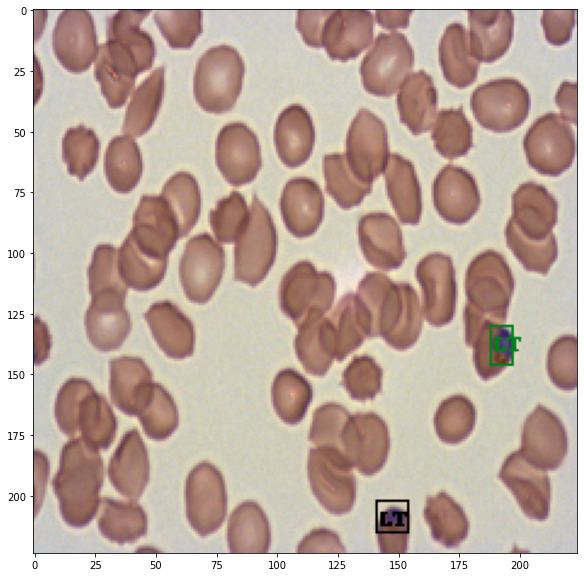

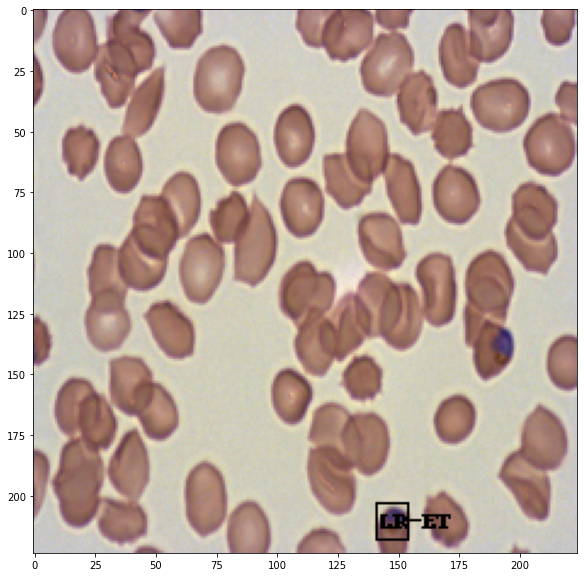

In [16]:
fig1 = plt.figure(figsize=(14,10))
plt.imshow(draw_bounding_boxes(img_int,target['boxes'],[classes[i] for i in target['labels'].tolist()],width=1).permute(1,2,0))
fig2 = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.70],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.70].tolist()], width=1
).permute(1, 2, 0))

In [1]:
classes = ['background', 'Esch','LT','LR-ET', 'Lsch', 'R', 'Seg', 'MT', 'DEBRIS', 'WBC']
for j in range(177):
    img, target = dataset_test[j]

    img_int = torch.tensor(img*255, dtype=torch.uint8)
    with torch.no_grad():
        prediction = model([img.to(device)])
        pred = prediction[0]
        #print(pred['scores'])
    fig1 = plt.figure(figsize=(14,10))
    plt.imshow(draw_bounding_boxes(img_int,target['boxes'],[classes[i] for i in target['labels'].tolist()],width=1).permute(1,2,0))
    fig2 = plt.figure(figsize=(14, 10))
    plt.imshow(draw_bounding_boxes(img_int,
        pred['boxes'][pred['scores'] > 0.70],
        [classes[i] for i in pred['labels'][pred['scores'] > 0.70].tolist()], width=1
    ).permute(1, 2, 0))

NameError: name 'dataset_test' is not defined

In [ ]:
classes = ['background','Ring','Trophozoite','Schizont','DEBRIS','WBC']
for j in range(177):
    img, target = dataset_test[j]

    img_int = torch.tensor(img*255, dtype=torch.uint8)
    with torch.no_grad():
        prediction = model([img.to(device)])
        pred = prediction[0]
        #print(pred['scores'])
    fig1 = plt.figure(figsize=(14,10))
    plt.imshow(draw_bounding_boxes(img_int,target['boxes'],[classes[i] for i in target['labels'].tolist()],width=1).permute(1,2,0))
    fig2 = plt.figure(figsize=(14, 10))
    plt.imshow(draw_bounding_boxes(img_int,
        pred['boxes'][pred['scores'] > 0.70],
        [classes[i] for i in pred['labels'][pred['scores'] > 0.70].tolist()], width=1
    ).permute(1, 2, 0))